In [7]:
import os
import json
import re
import statistics
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import date

# ------------------------------------------------------------------#
# 1. Konfiguration: Cafeterias, Datei-Pfad und Regex
# ------------------------------------------------------------------#
cafeterias = {
    "Mensa Leopoldstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_411_-de.html",
    "Mensa Arcisstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_421_-de.html",
    "Mensa Weihenstephan": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_423_-de.html",
    "Mensa Garching": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_422_-de.html",
    "StuBistro Garching": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_426_-de.html",
    "StuBistro WST Akademie": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_456_-de.html",
    "StuBistro Olympiacampus": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_425_-de.html",
    "StuBistro BEP": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_451_-de.html",
    "StuBistro Arcisstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_450_-de.html",
    "StuBistro Goethestr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_418_-de.html",
    "StuBistro Schellingstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_416_-de.html",
    "StuBistro Adalbertstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_452_-de.html",
    # Weitere Mensa- oder Cafeteria-URLs hier ergänzen
}

# Name der JSON-Datei, in der alle Daten gesammelt werden
DATA_FILE = "cafeteria_emissions.json"

# ------------------------------------------------------------------#
# 2. Hilfsfunktion: CO₂-Daten aus <li>-Elementen extrahieren
# ------------------------------------------------------------------#
def extract_emissions_from_items(meal_items):
    """
    Extrahiert aus einer Liste von <li class="c-menu-dish-list__item">-Elementen
    pro Kategorie alle CO₂-Werte und gibt ein Dictionary zurück:
        { Kategorie (str) : [co2_wert_1, co2_wert_2, ...] }
    """
    emissions = {}
    for item in meal_items:
        # (a) Kategorie aus <span class="stwm-artname">
        cat_span = item.find("span", class_="stwm-artname")
        category = cat_span.get_text(strip=True) if cat_span else "Sonstiges"

        # (b) CO₂-Wert aus dem Attribut data-essen-co2-wert
        co2_str = item.get("data-essen-co2-wert", "").strip()
        if not co2_str:
            continue
        try:
            co2_value = float(co2_str.replace(",", "."))
        except ValueError:
            continue

        emissions.setdefault(category, []).append(co2_value)

    return emissions

# ------------------------------------------------------------------#
# 3. Hilfsfunktionen: Zusammenfassung und Gesamtmittel berechnen
# ------------------------------------------------------------------#
def summarize_categories(emissions_dict):
    """
    Erstellt aus einem Dictionary {Kategorie: [co2_werte]} einen Dictionary
    mit den kategoriespezifischen Zusammenfassungen:
        { Kategorie: {"n_meals": int, "avg_co2": float}, ... }
    """
    summary = {}
    for category, values in emissions_dict.items():
        n_meals = len(values)
        avg_co2 = round(statistics.fmean(values), 1)
        summary[category] = {
            "n_meals": n_meals,
            "avg_co2": avg_co2
        }
    return summary

def calculate_overall_average_from_emissions(emissions_dict):
    """
    Berechnet das arithmetisches Mittel über alle Einzelwerte aus einem 
    Dictionary {Kategorie: [co2_werte]}. Gibt None zurück, falls keine Daten.
    """
    all_values = [val for sublist in emissions_dict.values() for val in sublist]
    return round(statistics.fmean(all_values), 1)

# ------------------------------------------------------------------#
# 4. Hauptlogik zur Datengewinnung pro Cafeteria
# ------------------------------------------------------------------#
def fetch_cafeteria_data(url):
    """
    Lädt den Speiseplan von der gegebenen URL herunter und gibt ein Dictionary
    zurück, dessen Schlüssel Datums-Strings im Format "DD.MM.YYYY" sind und
    dessen Werte wiederum Dictionaries enthalten mit
      - "categories": kategoriespezifische Zusammenfassung,
      - "overall_avg": Gesamtmittel für dieses Datum.
    Falls keine datenbezogenen Abschnitte gefunden werden, wird ein leeres Dict zurückgegeben.
    """
    result = {}
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    # Selektiere alle <div class="c-schedule__item">-Blöcke
    schedule_items = soup.select("div.c-schedule__item")
    if not schedule_items:
        return result

    for block in schedule_items:
        header_div = block.find("div", class_=re.compile(r"c-schedule__header"))
        if not header_div:
            continue

        strong_tag = header_div.find("strong")
        if not strong_tag:
            continue

        date_str = strong_tag.get_text(strip=True)  # z.B. "02.06.2025"

        menu_list = block.find("ul", class_="c-menu-dish-list")
        if not menu_list:
            # Keine Gerichte an diesem Datum
            continue

        meal_items = menu_list.select("li.c-menu-dish-list__item")
        if not meal_items:
            continue

        # CO₂-Werte nach Kategorie extrahieren
        emissions_dict = extract_emissions_from_items(meal_items)
        if not emissions_dict:
            continue

        # Kategoriespezifische Zusammenfassung und Gesamtmittel berechnen
        categories_summary = summarize_categories(emissions_dict)
        overall_avg = calculate_overall_average_from_emissions(emissions_dict)

        result[date_str] = {
            "categories": categories_summary,
            "overall_avg": overall_avg
        }

    return result

# ------------------------------------------------------------------#
# 5. Laden vorhandener Daten oder Erzeugen neuer Struktur
# ------------------------------------------------------------------#
if os.path.exists(DATA_FILE):
    with open(DATA_FILE, "r", encoding="utf-8") as f:
        all_data = json.load(f)
else:
    # Wenn Datei nicht existiert, legen wir leeres Grundgerüst an
    all_data = {caf_name: {} for caf_name in cafeterias.keys()}

# ------------------------------------------------------------------#
# 6. Abgleich und Aktualisierung der Datenbank
# ------------------------------------------------------------------#
updated = False  # Flag, um festzustellen, ob wir etwas hinzugefügt haben

for caf_name, url in cafeterias.items():
    try:
        print(f"Abrufen und Verarbeiten: {caf_name}")
        new_data = fetch_cafeteria_data(url)
    except Exception as e:
        print(f"  Fehler beim Abrufen von {caf_name}: {e}")
        continue

    # Bestehende Daten dieser Cafeteria
    existing_dates = set(all_data.get(caf_name, {}).keys())

    for date_str, info in new_data.items():
        if date_str not in existing_dates:
            # Neu hinzugefügtes Datum → in den Datensatz übernehmen
            all_data.setdefault(caf_name, {})[date_str] = info
            print(f"  Datum hinzugefügt: {date_str} ({caf_name})")
            updated = True

# ------------------------------------------------------------------#
# 7. Speichern, falls sich etwas geändert hat
# ------------------------------------------------------------------#
if updated:
    with open(DATA_FILE, "w", encoding="utf-8") as f:
        json.dump(all_data, f, ensure_ascii=False, indent=2)
    print(f"\nAlle neuen Daten wurden in '{DATA_FILE}' gespeichert.")
else:
    print("\nKeine neuen Daten gefunden. Datei wurde nicht verändert.")

Abrufen und Verarbeiten: Mensa Leopoldstr.
Abrufen und Verarbeiten: Mensa Arcisstr.
Abrufen und Verarbeiten: Mensa Weihenstephan
Abrufen und Verarbeiten: Mensa Garching
Abrufen und Verarbeiten: StuBistro Garching
Abrufen und Verarbeiten: StuBistro WST Akademie
Abrufen und Verarbeiten: StuBistro Olympiacampus
Abrufen und Verarbeiten: StuBistro BEP
Abrufen und Verarbeiten: StuBistro Arcisstr.
Abrufen und Verarbeiten: StuBistro Goethestr.
Abrufen und Verarbeiten: StuBistro Schellingstr.
Abrufen und Verarbeiten: StuBistro Adalbertstr.

Keine neuen Daten gefunden. Datei wurde nicht verändert.


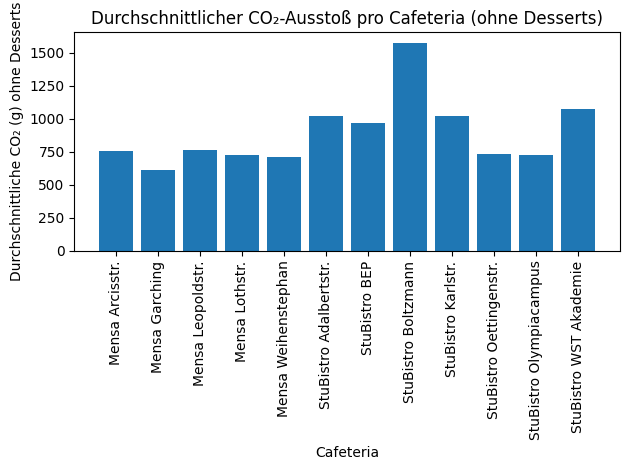

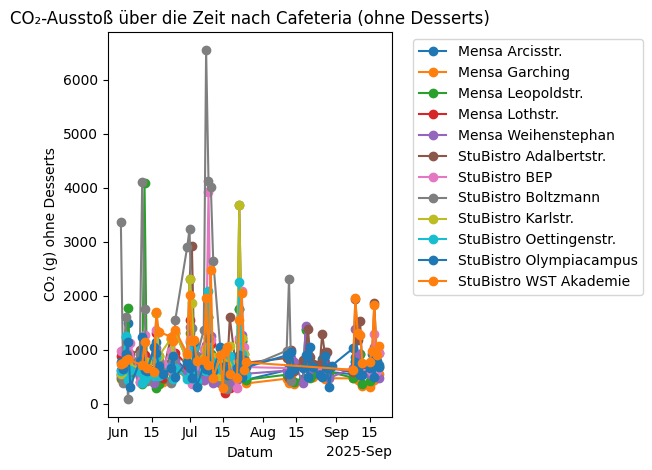


Durchschnittliche Emission pro Cafeteria (ohne Desserts):
| cafeteria               |   avg_emissions |
|-------------------------|-----------------|
| Mensa Arcisstr.         |         758.325 |
| Mensa Garching          |         612.673 |
| Mensa Leopoldstr.       |         764.187 |
| Mensa Lothstr.          |         724.305 |
| Mensa Weihenstephan     |         706.878 |
| StuBistro Adalbertstr.  |        1019.23  |
| StuBistro BEP           |         965.248 |
| StuBistro Boltzmann     |        1575.76  |
| StuBistro Karlstr.      |        1020.67  |
| StuBistro Oettingenstr. |         732.984 |
| StuBistro Olympiacampus |         728.137 |
| StuBistro WST Akademie  |        1077.65  |

Gesamt-Durchschnittlicher CO₂-Ausstoß (alle Cafeterias & alle Daten, ohne Desserts): 860.5 g CO₂e
Durchschnittlicher CO₂-Ausstoß pro veganem Gericht: 289.9 g CO₂


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate
from datetime import datetime

# ------------------------------------------------------------------#
# 1. JSON-Datei laden und DataFrame erstellen (ohne Desserts)
# ------------------------------------------------------------------#
DATA_FILE = "cafeteria_emissions.json"
with open(DATA_FILE, "r", encoding="utf-8") as f:
    all_data = json.load(f)

records = []
for cafeteria, dates in all_data.items():
    for date_str, info in dates.items():
        dt = datetime.strptime(date_str, "%d.%m.%Y")
        categories = info.get("categories", {})

        total_sum = 0.0
        total_count = 0
        for cat, vals in categories.items():
            if "Dessert" in cat:
                continue
            n = vals["n_meals"]
            avg = vals["avg_co2"]
            total_sum += avg * n
            total_count += n

        overall_emissions = (total_sum / total_count) if total_count > 0 else None

        records.append({
            "cafeteria": cafeteria,
            "date": dt,
            "overall_emissions": overall_emissions
        })

df_emissions = pd.DataFrame(records).sort_values(["cafeteria", "date"])
df_emissions = df_emissions.dropna(subset=["overall_emissions"])

# ------------------------------------------------------------------#
# 2. Metriken berechnen (ohne Desserts)
# ------------------------------------------------------------------#
avg_by_cafeteria_emissions = (
    df_emissions
    .groupby("cafeteria")["overall_emissions"]
    .mean()
    .reset_index()
)

range_by_date_emissions = (
    df_emissions
    .groupby("date")["overall_emissions"]
    .agg(lambda x: x.max() - x.min())
    .reset_index()
    .rename(columns={"overall_emissions": "emission_range_emissions"})
)

# ------------------------------------------------------------------#
# 3. Visualisierungen (ohne Desserts)
# ------------------------------------------------------------------#
# 3.1 Balkendiagramm
plt.figure()
plt.bar(avg_by_cafeteria_emissions["cafeteria"], avg_by_cafeteria_emissions["overall_emissions"])
plt.xticks(rotation=90)
plt.xlabel("Cafeteria")
plt.ylabel("Durchschnittliche CO₂ (g) ohne Desserts")
plt.title("Durchschnittlicher CO₂-Ausstoß pro Cafeteria (ohne Desserts)")
plt.tight_layout()
plt.show()

# 3.2 Liniendiagramm: CO₂-Ausstoß über die Zeit je Cafeteria (ohne Desserts)
plt.figure()
ax = plt.gca()
for cafeteria_name, group in df_emissions.groupby("cafeteria"):
    ax.plot(group["date"], group["overall_emissions"], marker="o", label=cafeteria_name)

ax.set_xlabel("Datum")
ax.set_ylabel("CO₂ (g) ohne Desserts")
ax.set_title("CO₂-Ausstoß über die Zeit nach Cafeteria (ohne Desserts)")

# Datumslocators und Formatter einstellen, damit die Datumsbeschriftungen nicht überlappen
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------#
# 4. Tabellarische Ausgabe mit tabulate (ohne Desserts)
# ------------------------------------------------------------------#
print("\nDurchschnittliche Emission pro Cafeteria (ohne Desserts):")
print(tabulate(
    avg_by_cafeteria_emissions.rename(columns={"overall_emissions": "avg_emissions"}), 
    headers="keys", 
    tablefmt="github", 
    showindex=False
))

# ------------------------------------------------------------------#
# 5. Gesamt-Durchschnitt über alle Cafeterias und Daten (ohne Desserts)
# ------------------------------------------------------------------#
overall_avg_all_emissions = df_emissions["overall_emissions"].mean()
print(f"\nGesamt-Durchschnittlicher CO₂-Ausstoß (alle Cafeterias & alle Daten, ohne Desserts): {overall_avg_all_emissions:.1f} g CO₂e")


# ------------------------------------------------------------------#
# 6. Gesamt-Durchschnitt über alle Veganen Gerichte in den Cafeterias
# ------------------------------------------------------------------#
total_vegan_sum = 0.0
total_vegan_count = 0

for cafeteria, dates in all_data.items():
    for date_str, info in dates.items():
        categories = info.get("categories", {})
        vegan_vals = categories.get("Vegan")
        if vegan_vals:
            n = vegan_vals["n_meals"]
            avg = vegan_vals["avg_co2"]
            total_vegan_sum += avg * n
            total_vegan_count += n

# 2. Durchschnitt berechnen (falls vegane Gerichte gefunden wurden)
if total_vegan_count > 0:
    avg_vegan_all = total_vegan_sum / total_vegan_count
    print(f"Durchschnittlicher CO₂-Ausstoß pro veganem Gericht: {avg_vegan_all:.1f} g CO₂")
else:
    print("Keine veganen Gerichte in den Daten gefunden.")

Ca. 25k gäste in der Mensa pro tag. Angenommen davon 10k von der TUM und jedes gericht wird gleichhäufig genommen => Emissionen pro tag sind (kilo CO₂)

In [3]:
emissionen_pro_tag_von_tum_kilo = round(overall_avg_all_emissions*10000)/1000
print(emissionen_pro_tag_von_tum_kilo)

8605.087


Das sind pro Jahr (Angenommen Mensa ist für 4 Wochen geschlossen)

In [4]:
emissionen_pro_jahr_tonnen = emissionen_pro_tag_von_tum_kilo * 5 * 48/1000 #angenommen mensa ist für vier wochen geschlossen (gleicht auch tage mit weniger gästen aus)
print(round(emissionen_pro_jahr_tonnen))

2065


Reduktionspotential (alle gerichte auf vegan umstellen):

In [5]:
reduktionspotential_pro_jahr_tonnen = emissionen_pro_jahr_tonnen - round(avg_vegan_all/overall_avg_all_emissions * emissionen_pro_jahr_tonnen)
print(round(reduktionspotential_pro_jahr_tonnen))

1369


In [6]:
print(round(avg_vegan_all/overall_avg_all_emissions, 3))

0.337
